Epoch [1/10], Average Loss: 0.051870
Epoch [2/10], Average Loss: 0.024454
Epoch [3/10], Average Loss: 0.019304
Epoch [4/10], Average Loss: 0.016957
Epoch [5/10], Average Loss: 0.015814
Epoch [6/10], Average Loss: 0.015032
Epoch [7/10], Average Loss: 0.014410
Epoch [8/10], Average Loss: 0.013923
Epoch [9/10], Average Loss: 0.013520
Epoch [10/10], Average Loss: 0.013162


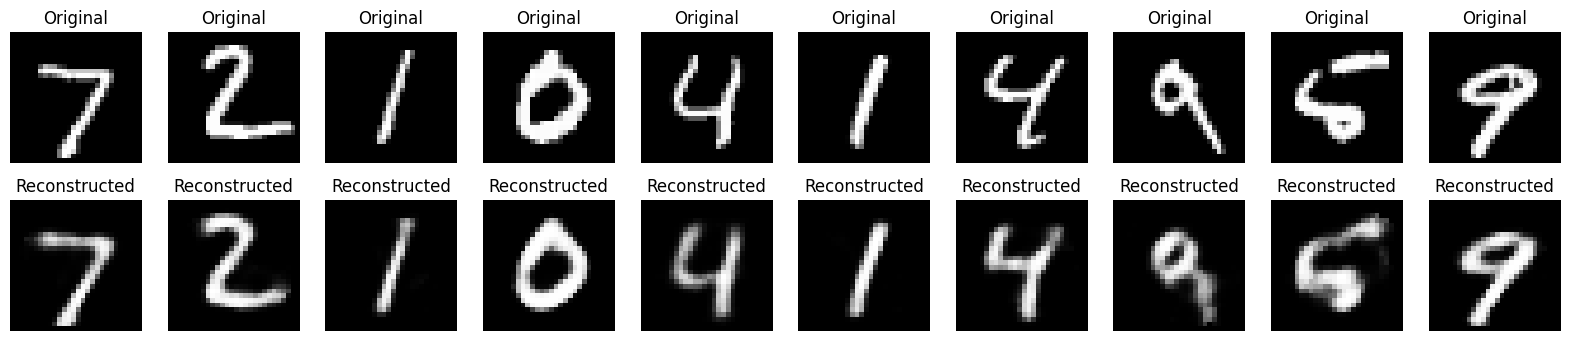

In [2]:
#Autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input
        z = self.encoder(x)  # Latent representation
        x_prime = self.decoder(z)  # Reconstructed output
        return x_prime

# Initialize model, loss, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img.view(-1, 784))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}')

# Reconstruct and visualize test images
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        reconstructed = model(img)
        break  # Process one batch for demonstration

# Visualize original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    ax.axis('off')
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')
    ax.axis('off')
plt.show()

Epoch [1/10], Average Loss: 190.449550
Epoch [2/10], Average Loss: 138.524062
Epoch [3/10], Average Loss: 127.467080
Epoch [4/10], Average Loss: 121.655599
Epoch [5/10], Average Loss: 118.155537
Epoch [6/10], Average Loss: 115.839335
Epoch [7/10], Average Loss: 114.215553
Epoch [8/10], Average Loss: 113.065740
Epoch [9/10], Average Loss: 112.151466
Epoch [10/10], Average Loss: 111.467391


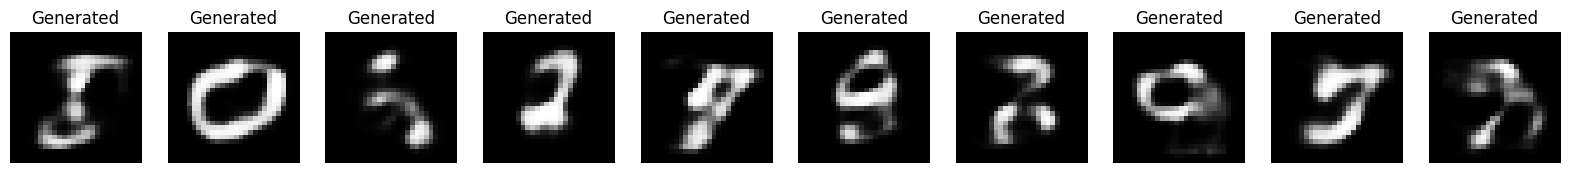

In [3]:
# VAEs
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
# Load and preprocess MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 128),nn.ReLU())
        self.fc_mu = nn.Linear(128, 32)  # Mean of latent space
        self.fc_logvar = nn.Linear(128, 32)  # Log-variance of latent space
        self.decoder = nn.Sequential(nn.Linear(32, 128),nn.ReLU(),nn.Linear(128, 784),nn.Sigmoid())
    def encode(self, x):
        x = x.view(-1, 784)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        return self.decoder(z)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_prime = self.decode(z)
        return x_prime, mu, logvar
# Loss function
def vae_loss(reconstructed, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(reconstructed, x.view(-1, 784), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div
# Initialize model, optimizer
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the VAE
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        recon, mu, logvar = model(img)
        loss = vae_loss(recon, img, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}')
# Generate and visualize samples
model.eval()
with torch.no_grad():
    z = torch.randn(10, 32)  # Sample from standard normal
    generated = model.decode(z)
# Visualize generated images
plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(generated[i].reshape(28, 28), cmap='gray')
    plt.title('Generated')
    ax.axis('off')
plt.show()

Epoch [1/20], D Loss: 0.4592, G Loss: 2.7526
Epoch [2/20], D Loss: 0.4741, G Loss: 2.1291
Epoch [3/20], D Loss: 0.5050, G Loss: 2.1544
Epoch [4/20], D Loss: 0.5580, G Loss: 2.0885
Epoch [5/20], D Loss: 0.5726, G Loss: 2.0912
Epoch [6/20], D Loss: 0.5533, G Loss: 2.1689
Epoch [7/20], D Loss: 0.5678, G Loss: 2.2041
Epoch [8/20], D Loss: 0.5491, G Loss: 2.2328
Epoch [9/20], D Loss: 0.5415, G Loss: 2.3058
Epoch [10/20], D Loss: 0.5455, G Loss: 2.3243
Epoch [11/20], D Loss: 0.5212, G Loss: 2.3914
Epoch [12/20], D Loss: 0.5138, G Loss: 2.4360
Epoch [13/20], D Loss: 0.5023, G Loss: 2.4925
Epoch [14/20], D Loss: 0.4898, G Loss: 2.5361
Epoch [15/20], D Loss: 0.4881, G Loss: 2.5597
Epoch [16/20], D Loss: 0.4742, G Loss: 2.6180
Epoch [17/20], D Loss: 0.4741, G Loss: 2.6378
Epoch [18/20], D Loss: 0.4630, G Loss: 2.6709
Epoch [19/20], D Loss: 0.4583, G Loss: 2.7062
Epoch [20/20], D Loss: 0.4426, G Loss: 2.7532


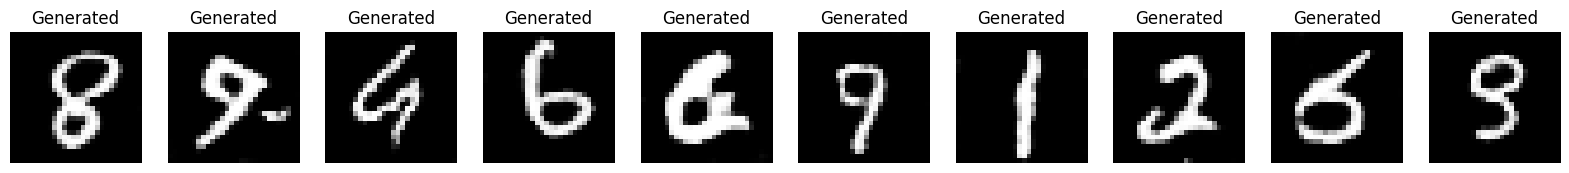

In [2]:
#DCGAN
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                           shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: z [batch, 100, 1, 1]
            nn.ConvTranspose2d(100, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State: [batch, 128, 7, 7]
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State: [batch, 64, 14, 14]
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()  # Output: [batch, 1, 28, 28] in [-1, 1]
        )
    
    def forward(self, z):
        z = z.view(-1, 100, 1, 1)  # Reshape noise to [batch, 100, 1, 1]
        return self.model(z)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: [batch, 1, 28, 28]
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: [batch, 64, 14, 14]
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State: [batch, 128, 7, 7]
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()  # Output: [batch, 1, 1, 1]
        )
    
    def forward(self, x):
        return self.model(x).view(-1, 1)  # Flatten to [batch, 1]

# Initialize models, loss, and optimizers
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, 
                         betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, 
                         betas=(0.5, 0.999))

# Training parameters
num_epochs = 20
z_dim = 100

# Train the DCGAN
for epoch in range(num_epochs):
    d_loss_total = 0
    g_loss_total = 0
    for data in train_loader:
        real_imgs, _ = data
        batch_size = real_imgs.size(0)
        
        # Labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # Train Discriminator
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_imgs)
        d_real_loss = criterion(real_outputs, real_labels)
        z = torch.randn(batch_size, z_dim)
        fake_imgs = generator(z)
        fake_outputs = discriminator(fake_imgs.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        d_loss_total += d_loss.item()
        
        # Train Generator
        g_optimizer.zero_grad()
        fake_outputs = discriminator(fake_imgs)
        g_loss = criterion(fake_outputs, real_labels)#Trick discriminator
        g_loss.backward()
        g_optimizer.step()
        g_loss_total += g_loss.item()
    
    # Print average losses
    avg_d_loss = d_loss_total / len(train_loader)
    avg_g_loss = g_loss_total / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {avg_d_loss:.4f},
          G Loss: {avg_g_loss:.4f}')

# Generate and visualize samples
generator.eval()
with torch.no_grad():
    z = torch.randn(10, z_dim)
    generated_imgs = generator(z)

# Visualize generated images
plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    # Denormalize from [-1, 1] to [0, 1] for display
    img = (generated_imgs[i].squeeze() + 1) / 2
    plt.imshow(img, cmap='gray')
    plt.title('Generated')
    ax.axis('off')
plt.show()

Epoch [1/15], Loss: 0.1360
Epoch [2/15], Loss: 0.1070
Epoch [3/15], Loss: 0.1055
Epoch [4/15], Loss: 0.1050
Epoch [5/15], Loss: 0.1048
Epoch [6/15], Loss: 0.1046
Epoch [7/15], Loss: 0.1045
Epoch [8/15], Loss: 0.1043
Epoch [9/15], Loss: 0.1042
Epoch [10/15], Loss: 0.1041
Epoch [11/15], Loss: 0.1040
Epoch [12/15], Loss: 0.1040
Epoch [13/15], Loss: 0.1039
Epoch [14/15], Loss: 0.1038
Epoch [15/15], Loss: 0.1038


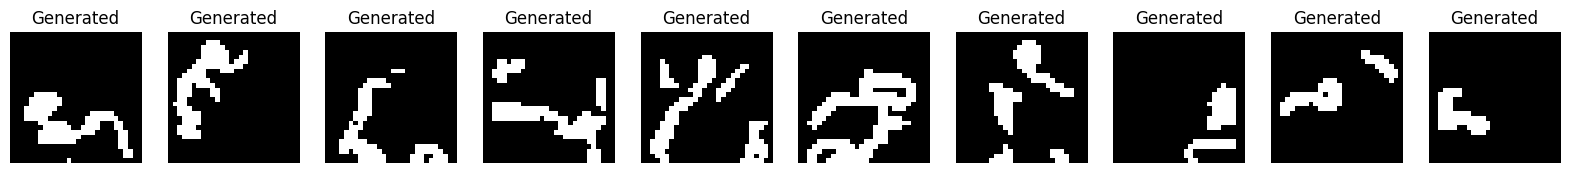

In [3]:
## Autoregressive Models: PixelCNN
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess MNIST dataset (binarized)
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()  # Binarize: pixels > 0.5 become 1, else 0
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define Masked Convolutional Layer
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        self.apply_mask()
    
    def apply_mask(self):
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        if self.mask_type == 'A':
            self.mask[:, :, kH//2, kW//2:] = 0  # Exclude current pixel and right
            self.mask[:, :, kH//2+1:] = 0       # Exclude below
        else:  # Mask B
            self.mask[:, :, kH//2, kW//2+1:] = 0  # Exclude right
            self.mask[:, :, kH//2+1:] = 0         # Exclude below
    
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

# Define PixelCNN Model
class PixelCNN(nn.Module):
    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            # Mask A for first layer (excludes current pixel)
            MaskedConv2d('A', in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            # Mask B for subsequent layers
            MaskedConv2d('B', 32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            MaskedConv2d('B', 32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # Output layer: predict Bernoulli probability for each pixel
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()  # Probability of pixel being 1
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize model, loss, and optimizer
model = PixelCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 15

# Train PixelCNN
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)  # BCE loss for log-likelihood
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Print average loss
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Generate samples
model.eval()
num_samples = 10
samples = torch.zeros(num_samples, 1, 28, 28)
with torch.no_grad():
    for i in range(28):
        for j in range(28):
            out = model(samples)
            probs = out[:, :, i, j]
            samples[:, :, i, j] = torch.bernoulli(probs)

# Visualize generated images
plt.figure(figsize=(20, 2))
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.title('Generated')
    ax.axis('off')
plt.show()

Epoch [1/15], Loss: -2356.8374
Epoch [2/15], Loss: -2415.4174
Epoch [3/15], Loss: -2415.4957
Epoch [4/15], Loss: -2415.5272
Epoch [5/15], Loss: -2415.5348
Epoch [6/15], Loss: -2415.5394
Epoch [7/15], Loss: -2415.5438
Epoch [8/15], Loss: -2415.5468
Epoch [9/15], Loss: -2415.5482
Epoch [10/15], Loss: -2415.5496
Epoch [11/15], Loss: -2413.9897
Epoch [12/15], Loss: -2415.5359
Epoch [13/15], Loss: -2415.5442
Epoch [14/15], Loss: -2415.5489
Epoch [15/15], Loss: -2415.5486


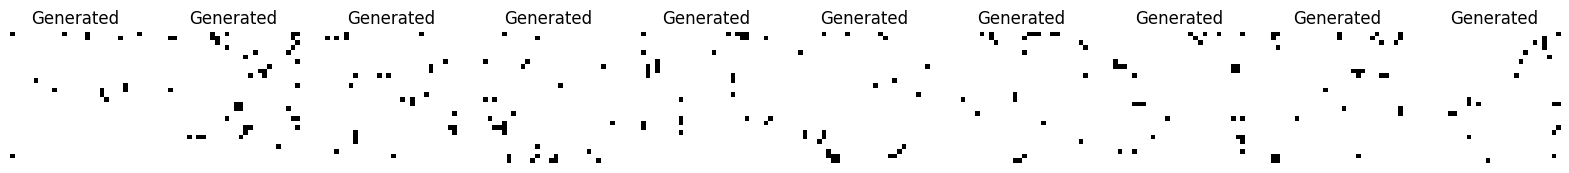

In [2]:
# Flow-Based Models RealNVP
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess MNIST dataset (binarized)
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()  # Binarize: pixels > 0.5 become 1, else 0
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define Coupling Layer for RealNVP (corrected for single-channel input)
class CouplingLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(CouplingLayer, self).__init__()
        self.s_net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels, 3, padding=1),
            nn.Tanh()  # Scale for stability
        )
        self.t_net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels, 3, padding=1)
        )
    
    def forward(self, x, forward=True):
        if forward:
            s = self.s_net(x)
            t = self.t_net(x)
            y = x * torch.exp(s) + t
            log_det = s.sum(dim=(1, 2, 3))  # Log-determinant
            return y, log_det
        else:  # Inverse
            s = self.s_net(x)
            t = self.t_net(x)
            y = (x - t) * torch.exp(-s)
            log_det = -s.sum(dim=(1, 2, 3))
            return y, log_det

# Define RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, num_layers=4, hidden_channels=64):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList([
            CouplingLayer(in_channels=1, hidden_channels=hidden_channels)
            for _ in range(num_layers)
        ])
    
    def forward(self, x, forward=True):
        log_det_sum = torch.zeros(x.size(0))
        z = x
        for layer in self.layers:
            z, log_det = layer(z, forward)
            log_det_sum += log_det
        return z, log_det_sum
    
    def log_likelihood(self, x):
        z, log_det = self.forward(x, forward=True)
        # Assume standard normal base distribution
        log_pz = -0.5 * (z ** 2 + np.log(2 * np.pi)).sum(dim=(1, 2, 3))
        return log_pz + log_det

# Initialize model, optimizer
model = RealNVP(num_layers=4, hidden_channels=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 15

# Train RealNVP
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, 1, 28, 28)  # Ensure correct shape
        optimizer.zero_grad()
        log_likelihood = model.log_likelihood(data)
        loss = -log_likelihood.mean()  # Negative log-likelihood
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Print average loss
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Generate samples
model.eval()
num_samples = 10
with torch.no_grad():
    z = torch.randn(num_samples, 1, 28, 28)  # Sample from normal
    samples, _ = model(z, forward=False)  # Inverse transformation
    samples = (samples > 0.5).float()  # Binarize

# Visualize generated images
plt.figure(figsize=(20, 2))
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.title('Generated')
    ax.axis('off')
plt.show()

Using device: cuda
Epoch [1/50], Loss: -279.4483
Epoch [2/50], Loss: -1864.9711
Epoch [3/50], Loss: -2438.9689
Epoch [4/50], Loss: -2424.1418
Epoch [5/50], Loss: -2552.4938
Epoch [6/50], Loss: -2619.8617
Epoch [7/50], Loss: -2673.4900
Epoch [8/50], Loss: -921.8351
Epoch [9/50], Loss: -538.2022
Epoch [10/50], Loss: -1689.6556
Epoch [11/50], Loss: -2306.3910
Epoch [12/50], Loss: -2426.0494
Epoch [13/50], Loss: -2745.6431
Epoch [14/50], Loss: -2819.2416
Epoch [15/50], Loss: -2806.7097
Epoch [16/50], Loss: -3351.1719
Epoch [17/50], Loss: -2906.7951
Epoch [18/50], Loss: -861.2561
Epoch [19/50], Loss: -800.9523
Epoch [20/50], Loss: -1063.7189
Epoch [21/50], Loss: -1282.8178
Epoch [22/50], Loss: -1480.4397
Epoch [23/50], Loss: -1715.8206
Epoch [24/50], Loss: -1946.0124
Epoch [25/50], Loss: -1854.6807
Epoch [26/50], Loss: -2018.4775
Epoch [27/50], Loss: -1834.5215
Epoch [28/50], Loss: -2366.3013
Epoch [29/50], Loss: -2510.0653
Epoch [30/50], Loss: -2585.7030
Epoch [31/50], Loss: -2651.1250
Epo

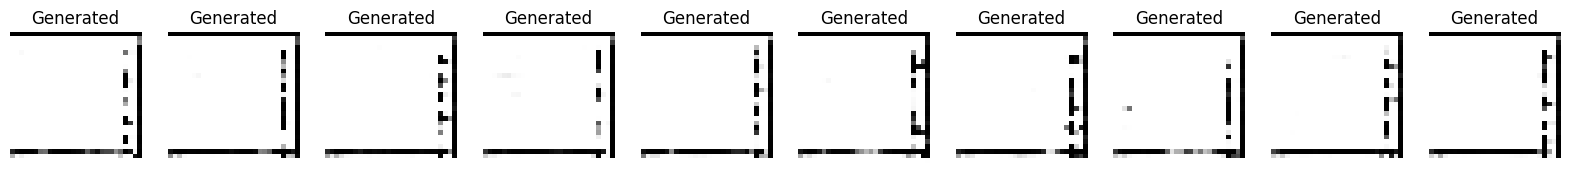

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


# Set random seed for reproducibility
torch.manual_seed(42)

# Check for GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess dataset (grayscale, normalized)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Define Coupling Layer for RealNVP (enhanced with batch norm)
class CouplingLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(CouplingLayer, self).__init__()
        self.s_net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels, 3, padding=1),
            nn.Tanh()  # Scale for stability
        )
        self.t_net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels, 3, padding=1)
        )
    
    def forward(self, x, forward=True):
        if forward:
            s = self.s_net(x)
            t = self.t_net(x)
            y = x * torch.exp(s) + t
            log_det = s.sum(dim=(1, 2, 3))  # Log-determinant
            return y, log_det
        else:  # Inverse
            s = self.s_net(x)
            t = self.t_net(x)
            y = (x - t) * torch.exp(-s)
            log_det = -s.sum(dim=(1, 2, 3))
            return y, log_det

# Define RealNVP Model (deeper and wider)
class RealNVP(nn.Module):
    def __init__(self, num_layers=8, hidden_channels=128):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList([
            CouplingLayer(in_channels=1, hidden_channels=hidden_channels)
            for _ in range(num_layers)
        ])
    
    def forward(self, x, forward=True):
        log_det_sum = torch.zeros(x.size(0), device=x.device)
        z = x
        for layer in self.layers:
            z, log_det = layer(z, forward)
            log_det_sum += log_det
        return z, log_det_sum
    
    def log_likelihood(self, x):
        z, log_det = self.forward(x, forward=True)
        # Assume standard normal base distribution
        log_pz = -0.5 * (z ** 2 + np.log(2 * np.pi)).sum(dim=(1, 2, 3))
        return log_pz + log_det

# Initialize model, optimizer
model = RealNVP(num_layers=8, hidden_channels=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Lower LR for stability

# Training parameters
num_epochs = 50

# Train RealNVP
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, 1, 28, 28).to(device)  # Ensure correct shape and device
        optimizer.zero_grad()
        log_likelihood = model.log_likelihood(data)
        loss = -log_likelihood.mean()  # Negative log-likelihood
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Print average loss
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Generate samples
model.eval()
num_samples = 10
with torch.no_grad():
    z = torch.randn(num_samples, 1, 28, 28).to(device)  # Sample from normal
    samples, _ = model(z, forward=False)  # Inverse transformation
    samples = torch.sigmoid(samples)  # Map to [0, 1] for visualization

# Visualize and save generated images
plt.figure(figsize=(20, 2))
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i].cpu().squeeze(), cmap='gray')
    plt.title('Generated')
    ax.axis('off')
plt.savefig('realnvp_output.png')
plt.show()